# Mask R-CNN - Train on Coco Dataset


In [1]:
# python 2 compability
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Import Python Packages
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Import Mobile Mask R-CNN Packages
from mmrcnn.config import Config
import coco
from mmrcnn import model as modellib,utils,visualize
from mmrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Coco Dataset directory
COCO_DIR = os.path.join(ROOT_DIR, 'data/coco')

Using TensorFlow backend.


## Configurations

In [2]:
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "mmrcnn_cocoperson"

    # GPU
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # COCO has 80 classes (1+80)

    # Architecture
    ARCH = "mobilenetv1"

    # Size Options
    #BACKBONE_STRIDES = [4, 8, 16, 32, 64] #resnet
    BACKBONE_STRIDES = [2, 4, 8, 16, 32] #mnv1
    #BACKBONE_STRIDES = [8, 16, 32] #mnv2
    #RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256) #resnet
    RPN_ANCHOR_SCALES = (8 , 16, 32, 64, 128)
    MINI_MASK_SHAPE = (56, 56) #resnet
    #MINI_MASK_SHAPE = (28, 28)

    # Input Resolution
    #IMAGE_MIN_DIM = 400
    IMAGE_MAX_DIM = 512

    
config = CocoConfig()
config.display()


Configurations:
ARCH                           mobilenetv1
BACKBONE_STRIDES               [2, 4, 8, 16, 32]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
M

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [4]:
# Training Dataset
classes = ['person']
dataset_train = coco.CocoDataset()
dataset_train.load_coco(COCO_DIR, "train", class_names=classes)
dataset_train.prepare()

# Validation Dataset
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val", class_names=classes)
dataset_val.prepare()

loading annotations into memory...
Done (t=13.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


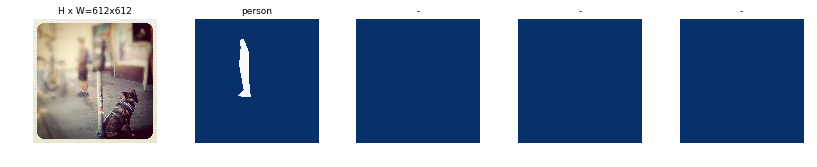

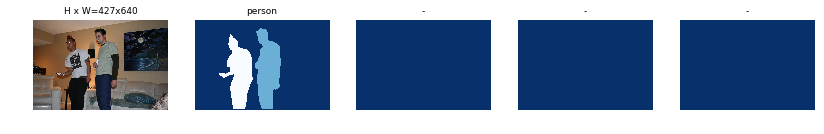

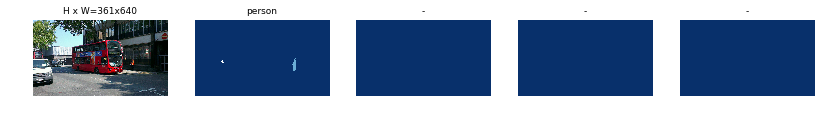

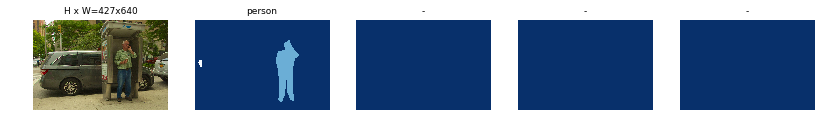

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", model_dir = MODEL_DIR, config=config)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
# Which weights to start with?
init_weights = "imagenet"  # imagenet, coco, or last

if init_weights == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_weights == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_weights == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

In [8]:
# Augmentation
augmentation = imgaug.augmenters.Fliplr(0.5)

In [9]:
# Training - Stage 1
# Finetune network heads
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=160,
            layers='heads',
            augmentation=augmentation)

Instructions for updating:
Use the retry module or similar alternatives.


Instructions for updating:
Use the retry module or similar alternatives.



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/gustav/workspace/Mobile_Mask_RCNN/logs/mmrcnn_cocoperson20180419T1336/mask_rcnn_mmrcnn_cocoperson_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
DEBUG:root:h,w,scale: 426,640,0.8
DEBUG:root:h,w,scale: 500,375,1.024
DEBUG:root:h,w,scale: 333,500,1.024
DEBUG:root:h,w,scale: 427,640,0.8
DEBUG:root:h,w,scale: 375,500,1.024
DEBUG:root:h,w,scale: 441,640,0.8
DEBUG:root:h,w,scale: 425,640,0.8
DEBUG:root:h,w,scale: 500,375,1.024
DEBUG:root:h,w,scale: 480,640,0.8
DEBUG:root:h,w,scale: 500,375,1.024
DEBUG:root:h,w,scale: 396,640,0.8
DEBUG:root:h,w,scale: 427,640,0.8
DE

Epoch 1/160


DEBUG:root:h,w,scale: 480,640,0.8
DEBUG:root:h,w,scale: 640,424,0.8
DEBUG:root:h,w,scale: 425,640,0.8
DEBUG:root:h,w,scale: 480,640,0.8
DEBUG:root:h,w,scale: 480,640,0.8
DEBUG:root:h,w,scale: 523,640,0.8
DEBUG:root:h,w,scale: 426,640,0.8
DEBUG:root:h,w,scale: 427,640,0.8
DEBUG:root:h,w,scale: 360,640,0.8
DEBUG:root:h,w,scale: 426,640,0.8
DEBUG:root:h,w,scale: 640,427,0.8
DEBUG:root:h,w,scale: 480,640,0.8
DEBUG:root:h,w,scale: 612,612,0.83660130719
DEBUG:root:h,w,scale: 608,640,0.8
DEBUG:root:h,w,scale: 428,640,0.8
DEBUG:root:h,w,scale: 244,640,0.8
DEBUG:root:h,w,scale: 640,428,0.8
DEBUG:root:h,w,scale: 640,427,0.8
DEBUG:root:h,w,scale: 640,480,0.8
DEBUG:root:h,w,scale: 500,281,1.024
DEBUG:root:h,w,scale: 215,350,1.46285714286
DEBUG:root:h,w,scale: 480,640,0.8
DEBUG:root:h,w,scale: 640,640,0.8
DEBUG:root:h,w,scale: 405,468,1.09401709402
DEBUG:root:h,w,scale: 429,640,0.8
DEBUG:root:h,w,scale: 640,480,0.8
DEBUG:root:h,w,scale: 640,426,0.8
DEBUG:root:h,w,scale: 425,640,0.8
DEBUG:root:h,w,s

InvalidArgumentError: flat indices[255, :] = [0, 261473] does not index into param (shape: [1,65472,2]).
	 [[Node: rpn_class_loss/GatherNd = GatherNd[Tindices=DT_INT64, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rpn_class_logits/concat, rpn_class_loss/Where)]]

Caused by op u'rpn_class_loss/GatherNd', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-af45ff11cc4e>", line 2, in <module>
    model = modellib.MaskRCNN(mode="training", model_dir = MODEL_DIR, config=config)
  File "mrcnn/model.py", line 2331, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "mrcnn/model.py", line 2504, in build
    [input_rpn_match, rpn_class_logits])
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/core.py", line 651, in call
    return self.function(inputs, **arguments)
  File "mrcnn/model.py", line 2503, in <lambda>
    rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
  File "mrcnn/model.py", line 1542, in rpn_class_loss_graph
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2840, in gather_nd
    "GatherNd", params=params, indices=indices, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): flat indices[255, :] = [0, 261473] does not index into param (shape: [1,65472,2]).
	 [[Node: rpn_class_loss/GatherNd = GatherNd[Tindices=DT_INT64, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rpn_class_logits/concat, rpn_class_loss/Where)]]


In [ ]:
# Training - Stage 2
# Finetune layers  stage 4 and up
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=120,
            layers="11M+",
            augmentation=augmentation)

In [ ]:
# Training - Stage 3
# Finetune all layers
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40,
            layers='all',
            augmentation=augmentation)

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mobile_mask_rcnn_coco_person.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:

image_ids = np.random.choice(dataset_val.image_ids, 10)

In [ ]:
image_ids

In [ ]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_ids[0], use_mini_mask=False)

In [ ]:
r['masks']